# DUC Datathon 2020
## Predicting Total Vertical Depth (TVD)

In this section of the competition we are tasked with building regression machine learning (or other)
model that will be able to predict TVD (True Vertical Depth)

In [89]:
# import general libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import prediction libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Data Import

In [90]:
# import well header data
well_header = pd.read_csv("../data/WellHeader_Datathon.csv")
# get submission ids for testing
submission_sample = pd.read_csv("../data/Submission_Sample.csv")

Selection of features to use, here are the feature types:

* **Labels** : EPAssetsId
* **Numeric**: TVD, total depth, KB elevation
* **Geographic**: Surface latitude and longitude
* **Categorical**: Well Profile, Field, formation

Note that the `field` feature will only be used for checking the latitude/longitude clustering.

### Data Cleaning

The data contains `NAN` values of `TVD` that do not need to be predicted. In the next step we filter out these values and only leave the wells that are on the `submission_sample` dataset or that contain real values of `TVD` that we can use to do the training on. 

In [91]:
# get ids for submission
EPAssetId_submission = submission_sample['EPAssetsId']

# filter well header to only include training points (non-NAN TVD) and submission ifs
well_header = well_header[
      (well_header['EPAssetsId'].isin(EPAssetId_submission)) | (pd.notna(well_header.TVD))]

well_header = well_header[[
                        'EPAssetsId',
                        'TVD','TotalDepth','Formation',
                        'Surf_Longitude','Surf_Latitude',
                        'BH_Longitude','BH_Latitude',
                        'WellProfile','Field','KBElevation',
                        # "Licensee",
                        # 'LicenseeParentCompanyName',
                        'LicenceDate',
                        'Pool'
                        ]]

well_header.sample(10)

EPAssetsId      TVD  TotalDepth Formation  Surf_Longitude  \
4824     1167595      NaN      1619.0    Viking     -108.927324   
4951     1151955   714.48      1438.0    Viking     -109.310281   
1723     2612579   883.18      2025.0    Viking     -111.093717   
2178     2614947      NaN      2405.0    Viking     -111.661917   
5186     1164792      NaN      1526.0    Viking     -109.475272   
1451     2605979  2526.78      5004.0   Montney     -119.971187   
7590     1166070   689.61      1908.0    Viking     -108.450905   
4505     1163221      NaN      2330.0    Viking     -108.743931   
7224     1166708   692.00      1903.0    Viking     -108.451119   
4021     1151219      NaN      1461.5    Viking     -109.219561   

      Surf_Latitude  BH_Longitude  BH_Latitude  WellProfile  \
4824      51.508993   -108.911986    51.507955   Horizontal   
4951      51.527508   -109.298675    51.526822   Horizontal   
1723      51.917449   -111.081350    51.910052  Directional   
2178      52.316547   -111.665098    52.331111  Directional   
5186      51.545406   -109.462783    51.546539   Horizontal   
1451      55.576162   -119.999593    55.591569   Horizontal   
7590      51.170252   -108.449843    51.158412   Horizontal   
4505      51.301428   -108.767994    51.302781   Horizontal   
7224      51.170251   -108.451946    51.158420   Horizontal   
4021      51.876617   -109.207193    51.876948   Horizontal   

                  Field  KBElevation LicenceDate                Pool  
4824          Avon Hill        698.9   11/9/2017    Avon Hill Viking  
4951   Whiteside Viking        702.8    7/6/2015    Whiteside Viking  
1723            Provost        784.1    5/3/2018  Commingled MFP9515  
2178            Provost        723.5   8/14/2018  Commingled MFP9515  
5186   Whiteside Viking        729.5   3/23/2017    Whiteside Viking  
1451  Pouce Coupe South        849.1   8/28/2017         Montney G4G  
7590              Plato        663.3   6/28/2017        Plato Viking  
4505        Plato North        715.3  12/16/2016  Plato North Viking  
7224              Plato        664.4   8/21/2017        Plato Viking  
4021          Kerrobert        717.3   4/21/2015    Kerrobert Viking

### Data Exploration

First, we can look a few cross-plots of certain variables of interest.

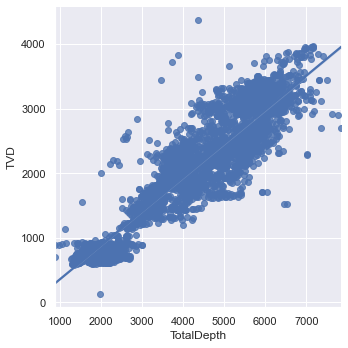

In [92]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", 
            data=well_header, fit_reg=True, height= 5, legend=True);

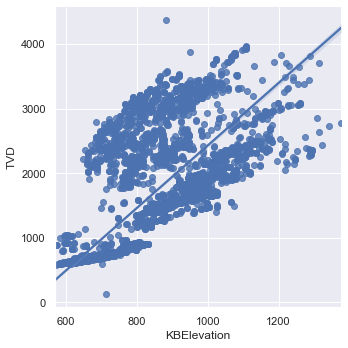

In [93]:
sns.set()
sns.lmplot( x="KBElevation", y="TVD", 
            # hue = 'WellProfile',
            data=well_header, fit_reg=True, height= 5, legend=True);

We can see from the two plots above that both `KVElevation` and `TotalDepth` are strongly correlated to `TVD`

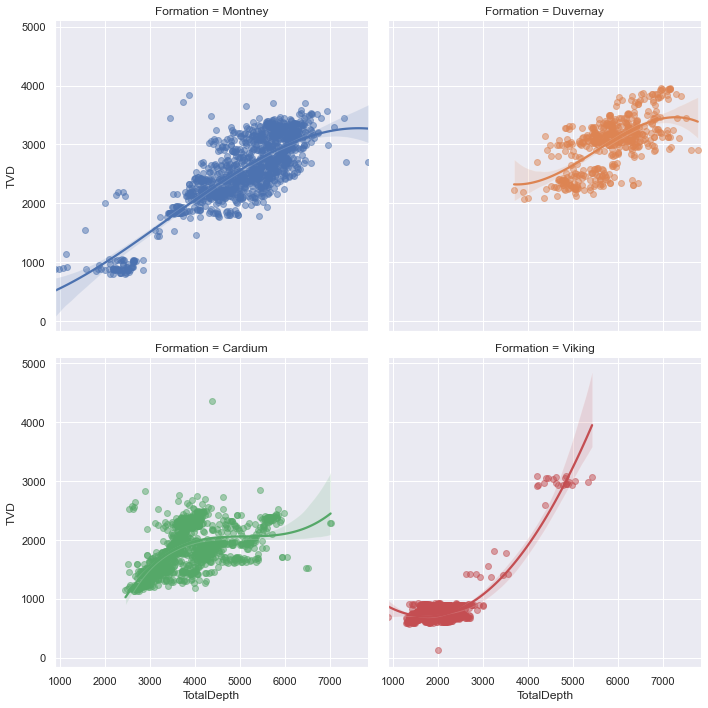

In [94]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", data=well_header, 
            fit_reg=True,hue='Formation',legend=False,col="Formation",col_wrap=2, height=5,order=3,
            scatter_kws={'alpha':0.5});

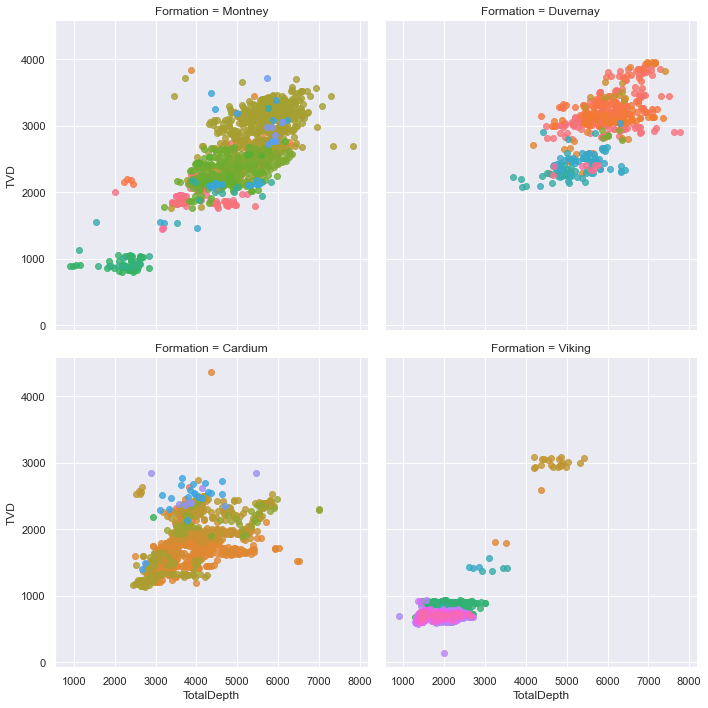

In [95]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", data=well_header, 
            fit_reg=False,hue='Field',legend=False,col="Formation",col_wrap=2, height=5);

The two plots above show that both `Formation` and `Field` are important contributors to the prediction of TVD.

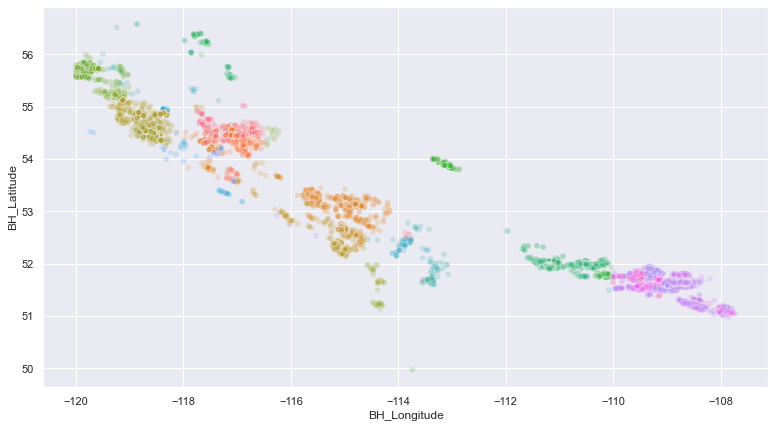

In [96]:
# label field column (for cluster metrics comparisons)
well_header['Field'] = well_header['Field'].astype('category')
well_header['Field_code'] = well_header['Field'].cat.codes

# quick plot
sns.set()
plt.figure(figsize = (13,7))
sns.scatterplot(well_header['BH_Longitude'], 
                well_header['BH_Latitude'],alpha=0.2,
                hue=well_header['Field'],legend=False
                )

We can see above that the data is clustered in certain geographical oil and gas fields. Below we use a clustering method called Density-based spatial clustering of applications with noise (DBSCAN).

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. In our case, this is benefitial.

For further information :

* https://en.wikipedia.org/wiki/DBSCAN
* https://scikit-learn.org/stable/modules/clustering.html#dbscan  

In our case, we use the `Field` feature as a metric on how the clusterin performs. However, the `Field` feature is not used in the final modelling.

In [143]:
# Compute DBSCAN clustering
from sklearn.cluster import DBSCAN
from sklearn import metrics

# cluster lat long coordinates
lat_longs = well_header[[
    'Surf_Longitude','Surf_Latitude',
#     'BH_Longitude','BH_Latitude'
    ]]
db = DBSCAN(eps=0.2, min_samples=2).fit(lat_longs)

# get sample
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labels_true = np.array(well_header.Field_code)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print out metrics
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lat_longs, labels))

Estimated number of clusters: 21
Estimated number of noise points: 5
Homogeneity: 0.336
Completeness: 0.995
V-measure: 0.502
Adjusted Rand Index: 0.132
Adjusted Mutual Information: 0.490
Silhouette Coefficient: 0.301


Below we run the clustering again but this time with a predicted output of cluster labels (using sci-kit learn function `fit_predict`)

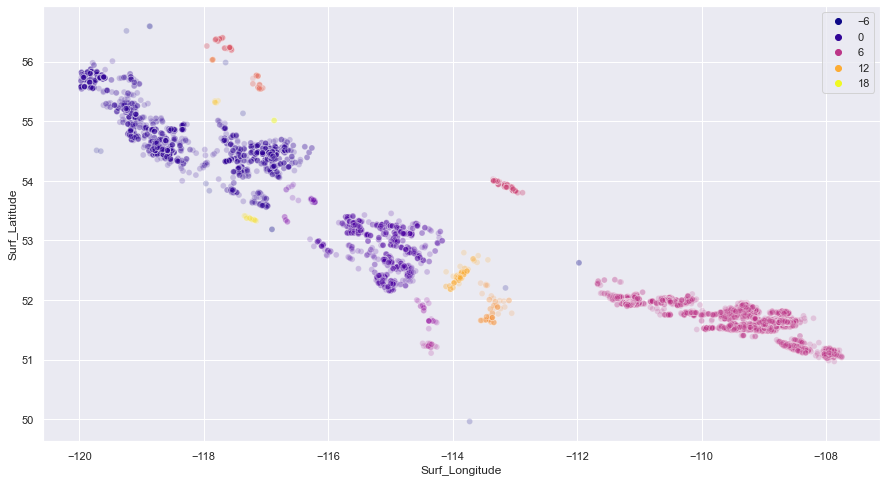

In [144]:
# re-run with prediction values
db = DBSCAN(eps=0.2, min_samples = 3)
clusters = db.fit_predict(lat_longs)

# quick plot with clusters
plt.figure(figsize = (15,8))
sns.scatterplot(well_header['Surf_Longitude'], 
                well_header['Surf_Latitude'],
                alpha=0.2,hue=clusters,palette="plasma")

# add clusters back to df
well_header['DBSCAN_Clusters']=clusters


Select colummns of interest

In [145]:
well_header_clean = well_header[[
                              'EPAssetsId',
                              'TVD',
                              'TotalDepth', 
                              'KBElevation',
                              'Formation', 
                              'WellProfile',
                              'DBSCAN_Clusters',
                              "Field",
                              'Pool',
                              'LicenceDate'
                              ]]

well_header_clean['LicenceDate'] = pd.to_datetime(well_header_clean.LicenceDate)

well_header_clean['UnixTime'] = (well_header_clean['LicenceDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')  

well_header_clean.sample(10)

EPAssetsId      TVD  TotalDepth  KBElevation Formation  WellProfile  \
493      2599075  1708.20      3382.0        952.8   Cardium   Horizontal   
6489     1163672      NaN      1670.0        693.9    Viking   Horizontal   
4623     1172340   679.99      2216.0        677.4    Viking   Horizontal   
692      2614619  2319.17      4767.0       1082.2   Cardium  Directional   
4506     1163487      NaN      2295.0        708.8    Viking   Horizontal   
945      2595507      NaN      6195.0        939.8   Montney   Horizontal   
1127     2616042  2679.58      6580.0        716.2   Montney  Directional   
4804     1167070      NaN      1769.0        615.4    Viking   Horizontal   
5083     1168641   722.49      1472.0        719.5    Viking   Horizontal   
2951     2607580  3393.08      6400.0       1007.7  Duvernay  Directional   

      DBSCAN_Clusters                           Field  \
493                 1                         Pembina   
6489                6                       Kerrobert   
4623                6                        Dodsland   
692                 1                         Ferrier   
4506                6                       Kerrobert   
945                 0                           Kakwa   
1127                0                        Elmworth   
4804                6  Viking  - Miscellaneous Area 2   
5083                6                Prairiedale East   
2951                1                 Willesden Green   

                         Pool LicenceDate    UnixTime  
493                   Cardium  2016-12-21  1482278400  
6489         Kerrobert Viking  2017-01-17  1484611200  
4623          Dodsland Viking  2018-11-21  1542758400  
692       Commingled Pool 001  2018-07-19  1531958400  
4506         Kerrobert Viking  2017-01-04  1483488000  
945         Montney Undefined  2016-08-25  1472083200  
1127        Montney Undefined  2018-06-18  1529280000  
4804                   Viking  2017-09-27  1506470400  
5083  Prairiedale East Viking  2018-01-23  1516665600  
2951     Temporary Commingled  2017-10-16  1508112000

### Predicting TVD using the Random Forests alorithm

In [146]:
# extract data to use in the validation stage
well_header_validation = well_header_clean[pd.isna(well_header_clean.TVD)]

# get unique values of formation, clusters, and well profile 
# from validation set to filter the training set
validation_clusters = well_header_validation.DBSCAN_Clusters.unique()
validation_formation = well_header_validation.Formation.unique()
validation_profile = well_header_validation.WellProfile.unique()
validation_field = well_header_validation.Field.unique()
validation_pool = well_header_validation.Pool.unique()

well_header_train = well_header_clean[
        pd.notna(well_header_clean.TVD) &  
        well_header_clean.Field.isin(validation_field) & 
        well_header_clean.DBSCAN_Clusters.isin(validation_clusters) & 
        well_header_clean.Formation.isin(validation_formation) &
        well_header_clean.WellProfile.isin(validation_profile)
        # well_header_clean.Pool.isin(validation_pool) 
        ]

Above we filter the data further so that the traning set contains the same unique features as the validation set, thereby obtaining a model that will match the validation set.

Below we split the training set into a test and training set to fit the model. We'll use the model on the validation set for prediction.

In [147]:
features = [
            'TotalDepth',
            'Formation',
            'WellProfile',
            'KBElevation',
            'DBSCAN_Clusters',
            'Field',
            'UnixTime',
        #     'Pool'
            ]

target = ['TVD']

X = well_header_train[features]
y = well_header_train[target]

# hot encode categorical variables
X = pd.get_dummies(X, 
                    columns=[
                            "Formation", 
                            "WellProfile",
                            "DBSCAN_Clusters",
                            'Field',
                        #     'Pool'
                            ])

# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

# fit regressor
regr = RandomForestRegressor(
                # max_depth=20
                )
regr.fit(X, y)

# get prediction
y_prediction = regr.predict(X_test)

# get RMSE
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print("The test RMSE is :",RMSE)


The test RMSE is : 23.385360917495323


### Predict and write TVD to file for submission

In [148]:
X_validation = well_header_validation[features]

# hot encode
X_validation = pd.get_dummies(X_validation, 
                    columns=[
                            "Formation", 
                            "WellProfile",
                            "DBSCAN_Clusters",
                            'Field'
                            ])

# get prediction
y_validation = regr.predict(X_validation)

well_header_submission = well_header_validation['EPAssetsId'].to_frame()

well_header_submission['TVD'] = y_validation

well_header_submission.to_csv("../predictions/predicted_tvd.csv",index=False)